In [ ]:
import pandas as pd
import numpy as np
import scipy
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
#from sklearn import datasets
np.random.seed(1234)
import random

import time

import os
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import TweetTokenizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_regression

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Dataloading

Define function to load imbd dataset:

In [ ]:
def load_imdb(data_path, label_type='binary'):
    """
    :param data_path: path where aclImdb folder is stored
    :param label_type: 'binary' if want binary 1 (positive review) and 0 (negative review), or 'score' if want the actual score (0-9 corresponding to 1-10/10)
    :return: train and test corpus and labels
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    out = {key: {'data': [], 'target': []} for key in ['train', 'test']}

    for key, val in out.items():
        for category in ['pos', 'neg']:
            train_path = os.path.join(imdb_data_path, key, category)

            for filename in sorted(os.listdir(train_path)):

                if filename.endswith('.txt'):
                    with open(os.path.join(train_path, filename), encoding='utf8') as f:
                        val['data'].append(f.read())
                    if label_type == 'binary':
                        # Label is a 1 if positive review and 0 if negative review
                        val['target'].append(0 if category == 'neg' else 1)
                    elif label_type == 'score':
                        # Label is the index of the score of the review 0-9 corresponding to a score of 1-10/10
                        val['target'].append(int(filename.split('_')[1].split('.')[0]) - 1)
                    else:
                        raise ValueError

    return out['train'], out['test']


def review_to_url(corpus, data_path):
    """
    Concatenates reviews if they are for the same movie. Requires that the reviews be kept in the same order as in the url txt file.
    Note that this operation does not preserve the order of the original corpus.
    """

    # Extract url for each document
    urls = []
    for filename in ('urls_pos.txt', 'urls_neg.txt'):
        with open(os.path.join(data_path, 'aclImdb', 'train', filename), encoding='utf8') as f:
            urls += f.read().split('\n')  # Split the URL string by newline
            # Last one is an empty string so remove it
            if urls[-1] == '':
                urls = urls[:-1]

    # Concatenate each document with the same url
    unique_urls = list(set(urls))
    url_corpus = ['' for _ in range(len(unique_urls))]
    for i, u in enumerate(urls):
        i_unique = unique_urls.index(u)
        if len(url_corpus[i_unique]) == 0:
            url_corpus[i_unique] += corpus[i]
        else:
            url_corpus[i_unique] += ' ' + corpus[i]  # Concatenate with a space to avoid merging two words

    return url_corpus

Define preprocessing and vectorizing classes for textual data:

In [ ]:
class CorpusPreproc():
    def __init__(self, lemmatizer=False, remove_stopwords=False, remove_punc=False):

        self.lemmatizer = lemmatizer
        self.remove_stopwords = remove_stopwords
        self.remove_punc = remove_punc

    def preproc(self, data):
        """Basic preprocessing of text data"""

        # Split text into tokens
        tweet = TweetTokenizer()
        out = [tweet.tokenize(sentence) for sentence in data]

        if self.lemmatizer:
            tag_map = defaultdict(lambda: wn.NOUN)
            tag_map['J'] = wn.ADJ
            tag_map['V'] = wn.VERB
            tag_map['R'] = wn.ADV

            out = [
                [nltk.stem.WordNetLemmatizer().lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(sent)]
                for sent in out]

        if self.remove_stopwords:
            stop_words = set(nltk.corpus.stopwords.words('english'))
            out = [[word for word in sentence if not word in stop_words] for sentence in out]

        if self.remove_punc:
            punc = string.punctuation
            out = [[word for word in sentence if word not in punc] for sentence in out]

        # Rejoin tokens
        out = [' '.join(sentence) for sentence in out]

        return out


class Vectorizer():
    def __init__(self, params, stop_words=None):
        self.tf = params['tf']
        self.min_df = params['min_df']
        self.max_df = params['max_df']
        self.ngram_range = params['ngram_range']
        self.use_idf = params['use_idf']
        self.stop_words = stop_words
        self.vectorizer = CountVectorizer(min_df=self.min_df, max_df=self.max_df, ngram_range=self.ngram_range, stop_words=self.stop_words)

        if self.tf:
            self.tfidf = TfidfTransformer(use_idf=self.use_idf)
        else:
            self.tfidf = None

    def fit_transform(self, data):
        """Fit vectorizer and transform data"""

        # Vectorize
        out = self.vectorizer.fit_transform(data)

        # TF
        if self.tfidf is not None:
            out = self.tfidf.fit_transform(out)

        return out

    def transform(self, data):
        """Transform data using already fitted vectorizer"""

        # Vectorize
        out = self.vectorizer.transform(data)

        # TF
        if self.tfidf is not None:
            out = self.tfidf.transform(out)

        return out


    def get_feature_names(self):
        return self.vectorizer.get_feature_names()

# Models

Naive Bayes Model

In [ ]:
class NaiveBayes:
    
    def __init__(self, config, n_classes=None):
        self.prob_w1 = None
        self.log_prob_w1 = None
        self.pi = None
        self.alpha = config['alpha']
        self.n_classes = n_classes       
    
    def fit(self, x, y):
        N, D = x.shape
        if self.n_classes is None:
          self.n_classes = np.max(y) + 1
        cnt_wi = np.zeros((self.n_classes,D))
        prob_wi = np.zeros((self.n_classes,D))
        log_prob_wi = np.zeros((self.n_classes,D))
        Nc = np.zeros(self.n_classes) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(self.n_classes):
            x_c = x[y == c]                         #slice all the elements from class c
            Nc[c] = x_c.shape[0]                      #get number of elements of class c
            #cnt_Ny[c] = 
            cnt_wi[c,:] = np.sum(x_c,0) + self.alpha
            prob_wi[c,:] = cnt_wi[c,:]/(x_c.sum().sum() + self.alpha*D)     
            
        self.prob_wi = prob_wi                                 # C x D                          # C x D
        self.log_prob_wi = np.ma.log(self.prob_wi).filled(0)
        self.pi = (Nc+self.alpha)/(N +self.alpha*self.n_classes)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

In [ ]:

def predict(self, xt):
    Nt, D = xt.shape
    pred = []
    # for numerical stability we work in the log domain
    log_prior = np.log(self.pi)
    #print(type(xt))
    for index, row in xt.iterrows():
      #print(index)
      log_likelihood = np.sum( np.multiply(np.array(row).reshape(1, -1), self.log_prob_wi ), 1    )
      ypred = np.argmax( log_prior + log_likelihood )
      #print(ypred)
      pred.append(ypred)
    return np.array(pred)

def evaluate_acc(self, true_y, target_y):
    return np.sum(target_y == true_y)/true_y.shape[0]

NaiveBayes.predict = predict
NaiveBayes.evaluate_acc = evaluate_acc  

Softmax Regression

In [ ]:
def softmax(x, axis=None):
    x = x - x.max(axis=1, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=1, keepdims=True)

class LogisticRegression:
    
    def __init__(self, params,n_classes=None):
        self.learning_rate = params["learning_rate"]
        self.max_iters = int(params["max_iters"])   #maximum number of iteration of gradient descent
        self.weights = []
        self.b = []
        self.n_classes = n_classes
        self.regul_type = params["regularization"]
        self.regul_const = params["reg_constant"]

    def fit(self,x,y):
      x = scipy.sparse.hstack((scipy.sparse.csr_matrix(np.ones((x.shape[0], 1))), x)) #adds a column of ones at the beginning of x to allow for a bias term
      classes = np.unique(y)
      self.weights = np.zeros((x.shape[1],len(classes)))
      y_c = np.zeros((len(y), len(classes)))
      for i, j in enumerate(y): #This performs one-hot encoding
        y_c[i, int(j)] = 1
      for epoch in range(self.max_iters):
          soft = softmax(x @ self.weights)
          y_diff = soft - y_c
          grad = (x.T @ y_diff)
          if self.regul_type == "l2":
            self.weights -= (self.learning_rate * (grad+self.regul_const*self.weights)) #apply L2 regularization
          else:
            self.weights -= (self.learning_rate * (grad+self.regul_const*np.sign(self.weights))) #apply L1 regularization
      self.weights = self.weights.T

    def predict(self, x):
      classes = np.arange(self.n_classes)
      x = scipy.sparse.hstack((scipy.sparse.csr_matrix(np.ones((x.shape[0], 1))), x))
      preds = [np.argmax(np.array([(xi @ weight) for weight in self.weights])) for xi in x.toarray()]
      return [classes[p] for p in preds]

    def evaluate_acc(self, true_y, target_y):
      return np.sum(target_y == true_y)/true_y.shape[0]

# Training

Define CV-related functions:

In [ ]:
def random_search(hyperparameters, n_samples, RAND=None):
    keys_to_permut = []
    vals_to_permut = []
    for key, val in hyperparameters.items():
        keys_to_permut.append(key)
        vals_to_permut.append(val)

    vals_permut = itertools.product(*vals_to_permut)
    random.seed(RAND)
    samples = random.sample(list(vals_permut), n_samples)

    return samples, keys_to_permut


def cross_validation_split(X, y, stratify=None, K=5):

    if stratify is not None:
        # Get classes for stratified sampling
        classes = np.unique(stratify)
        # Get index for each class
        i_targets = []
        class_test_size = []
        for c in classes:
            i_c = np.asarray(stratify == c).nonzero()[0]
            i_targets.append(i_c)
            class_test_size.append(round(len(i_c) / K))
    else:
        classes = [0]  # No stratification by class, assume all the same
        class_test_size = len(stratify)
        i_targets = np.arange(len(stratify))

    # Prepare K-folds output
    splits = [{'train': {'X': [], 'y': []},
               'val': {'X': [], 'y': []}} for _ in range(K)]

    # Loop through each class and sample proportionally from each
    for i_fold in range(K):
        all_val_i = np.array([])
        # Otherwise sample proportionally from each class to create a test set
        for i_class in range(len(classes)):
            if i_fold == K - 1:
                # If last fold whatever is left in the index bank is what is used as the last test set
                val_i = random.sample(range(0, len(i_targets[i_class])), len(i_targets[i_class]))
            else:
                val_i = random.sample(range(0, len(i_targets[i_class])), class_test_size[i_class])
            # Add test samples from this class to all samples for this test fold
            if len(all_val_i) == 0:
                all_val_i = i_targets[i_class][val_i]
            else:
                all_val_i = np.concatenate((all_val_i, i_targets[i_class][val_i]), axis=0)
            # Remove these samples so that the next test fold is sampled without replacement
            i_targets[i_class] = np.delete(i_targets[i_class], val_i)

        # Save validation split
        random.shuffle(all_val_i)  # Need to random shuffle
        splits[i_fold]['val']['X'] = [X[i] for i in all_val_i]
        splits[i_fold]['val']['y'] = y[all_val_i]
        # Save training split
        all_train_i = np.arange(y.shape[0])
        all_train_i = np.delete(all_train_i, all_val_i)
        random.shuffle(all_train_i) # Need to random shuffle
        splits[i_fold]['train']['X'] = [X[i] for i in all_train_i]
        splits[i_fold]['train']['y'] = y[all_train_i]

    return splits

def kfoldCV(splits, model):
    all_metrics = []
    for split in splits:

        model.fit(split['train']['X'], split['train']['y'])
        y_pred = model.predict(split['val']['X'])
        all_metrics.append(model.evaluate_acc(split['val']['y'], y_pred))

    avg_metric = np.average(all_metrics)

    return avg_metric


def tuning_loop(splits, samples, keys, model_type='NaiveBayes', n_classes=None, stop_words=None, verbose=False):

    all_metrics = []
    results_experiment = {}
    # Loop through each set of hyperparameters
    for params in samples:
        # Recreate a dict format for parameters
        hyperparameters = {key: val for key, val in zip(keys, params)}

        # Vectorize data
        if hyperparameters['use_idf']:
            # If use_idf is true tf needs to be true
            hyperparameters['tf'] = True

        v = Vectorizer(hyperparameters, stop_words=stop_words)

        # Create a split copy that you will further preprocess
        splits_tune = []
        for split in splits:
            # Vectorize each split
            splits_tune.append({'train': {'X': v.fit_transform(split['train']['X']).copy(),
                                          'y': split['train']['y']},
                                'val': {'X': v.transform(split['val']['X']).copy(),
                                        'y': split['val']['y']}})
            # Prepare data for input into model
            if model_type is "NaiveBayes":
                # Convert input into pandas sparse dataframe
                splits_tune[-1]['train']['X'] = pd.DataFrame.sparse.from_spmatrix(splits_tune[-1]['train']['X'])
                splits_tune[-1]['val']['X'] = pd.DataFrame.sparse.from_spmatrix(splits_tune[-1]['val']['X'])
            elif model_type is "LogisticRegression":
                # Convert input into pandas sparse dataframe
                splits_tune[-1]['train']['X'] = pd.DataFrame.sparse.from_spmatrix(splits_tune[-1]['train']['X'])
                splits_tune[-1]['val']['X'] = pd.DataFrame.sparse.from_spmatrix(splits_tune[-1]['val']['X'])
            else:
                raise NotImplementedError

        # initialize model
        start = time.time()
        model = eval(model_type)(hyperparameters, n_classes=n_classes)

        all_metrics.append(kfoldCV(splits_tune, model))

        # Print metric
        if verbose:
          print("\nHyperparameters:")
          print(hyperparameters)
          print("Accuracy: " + str(all_metrics[-1]) + "\n")
          results_experiment[", ".join("=".join((str(k),str(v))) for k,v in hyperparameters.items())]= all_metrics[-1]

    best_samples = samples[np.argmax(all_metrics)]
    # Recreate a dict format for parameters
    best_params = {key: val for key, val in zip(keys, best_samples)}
    best_metric = np.max(all_metrics)

    if verbose:
      pd.DataFrame(results_experiment.items()).to_excel("output_"+model_type+".xlsx")
    print('Best hyperparameters ' + model_type + ':')
    print(best_params)
    print('Best average validation metric ' + model_type + ': ' + str(best_metric))

    return best_params, best_metric

Set random seed for reproduceability

In [ ]:
# Set random seed
RAND = 0
random.seed(RAND)

# Experiment 1: Optimizing both models on both datasets using RandomSearch and comparing best performance

In [ ]:
# Load hyperparameters for logistic regression
hyperparameters_lr = {
    'max_df': (0.2, 0.35, 0.5, 0.75),
    'min_df': (2, 5, 7, 10),
    'use_idf': (False,True),
    'ngram_range': ((1, 1),),
    'tf': (False,True),
    "max_iters": (100,),
    "learning_rate": (0.1, 0.01, 0.001, 0.0001),
    "regularization": ("l1","l2"),
    "reg_constant": (0,0.1,0.5,0.9)
}

 # Load hyperparameters for NaiveBayes
hyperparameters_nb = {
    'max_df': (0.2, 0.35, 0.5, 0.75),
    'min_df': (2, 5, 7, 10),
    'use_idf': (False,True),
    'ngram_range': ((1, 1),),
    'tf': (False,True),
    'alpha': (0, 0.15, 0.5, 0.75, 0.9, 1)
 }

# Use the following format if you just want to run the one set of hyperparameters for each model:
#hyperparameters_nb = {'max_df': (0.2,), 'min_df': (2,), 'use_idf': (True,), 'ngram_range': ((2, 2),), 'tf': (True,), 'alpha': (0.5,)}
#hyperparameters_lr = {'max_df': (0.2,), 'min_df': (10,), 'use_idf': (False,), 'ngram_range': ((1, 1),), 'tf': (False,), 'max_iters': (100,), 'learning_rate': (0.1,), 'regularization': ('l2',), 'reg_constant': (0,)}

Train on 20news group dataset:

In [ ]:
# 20newsgroup dataset

# Load 20newsgroups
train_news = fetch_20newsgroups(subset='train', remove=(['headers', 'footers', 'quotes']))
test_news = fetch_20newsgroups(subset='test', remove=(['headers', 'footers', 'quotes']))

cp_news = CorpusPreproc(lemmatizer=True,
                        remove_stopwords=True,
                        remove_punc=True)

# Preprocess train set
X_news_train = cp_news.preproc(train_news.data)
y_news_train = np.array(train_news.target)
n_classes = np.unique(y_news_train).shape[0]

# Load K-fold splits
news_splits = cross_validation_split(X_news_train, y_news_train, stratify=y_news_train, K=5)

# ---- Tune for hyperparameters NAIVE BAYES ----
print("Tuning NAIVE BAYES on 20NEWSGROUP:")
samples, keys = random_search(hyperparameters_nb, n_samples=50, RAND=RAND)
best_params, best_metric = tuning_loop(news_splits, samples, keys, model_type='NaiveBayes', n_classes=n_classes, verbose=True)

# Final test set using best hyperparameters
# Preprocess test set
X_news_test = cp_news.preproc(test_news.data)
y_news_test = np.array(test_news.target)

# Vectorize data
if best_params['use_idf']:
    # If use_idf is true tf needs to be true
    best_params['tf'] = True

v = Vectorizer(best_params)
X_news_train = pd.DataFrame.sparse.from_spmatrix(v.fit_transform(X_news_train))
X_news_test = pd.DataFrame.sparse.from_spmatrix(v.transform(X_news_test))

# initialize model
model = NaiveBayes(best_params, n_classes=n_classes)

# Train and test
model.fit(X_news_train, y_news_train)
y_pred = model.predict(X_news_test)
test_acc = model.evaluate_acc(y_news_test, y_pred)
print('Test accuracy using best hyperparameters NAIVE BAYES on 20NEWSGROUP: ' + str(test_acc))



Tuning NAIVE BAYES on 20NEWSGROUP:
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>

Hyperparameters:
{'max_df': 0.5, 'min_df': 2, 'use_idf': False, 'ngram_range': (1, 1), 'tf': False, 'alpha': 1}
Accuracy: 0.6758891302957336

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>

Hyperparameters:
{'max_df': 0.5, 'min_df': 2, 'use_idf': True, 'ngram_range': (1, 1), 'tf': True, 'alpha': 1}
Accuracy: 0.702670002845487

Best hyperparameters NaiveBayes:
{'max_df': 0.5, 'min_df': 2, 'use_idf': True, 'ngram_range': (1, 1), 'tf': True, 'alpha': 1}
Best average validation metric NaiveBayes: 0.702670002845487
<class 'pandas.core.frame.DataFrame'>
Test accuracy using best hyperparameters NAIVE BAYES on 20NEWSGROUP: 0.6688794476898566


In [ ]:
# ---- Tune for hyperparameters LOGISTIC REGRESSION ----
print("Tuning LOGISTIC REGRESSION on 20NEWSGROUP:")
samples, keys = random_search(hyperparameters_lr, n_samples=40, RAND=RAND)
best_params, best_metric = tuning_loop(news_splits, samples, keys, model_type='LogisticRegression', n_classes=n_classes, verbose=True)

# Final test set using best hyperparameters
# initialize model
model = LogisticRegression(best_params, n_classes=n_classes)

# Train and test
model.fit(X_news_train, y_news_train)
y_pred = model.predict(X_news_test)
test_acc = model.evaluate_acc(y_news_test, y_pred)
print('Test accuracy using best hyperparameters LOGISTIC REGRESSION on 20NEWSGROUP: ' + str(test_acc))

Tuning LOGISTIC REGRESSION on 20NEWSGROUP:

Hyperparameters:
{'max_df': 0.75, 'min_df': 2, 'use_idf': False, 'ngram_range': (1, 1), 'tf': True, 'max_iters': 100, 'learning_rate': 0.01, 'regularization': 'l1', 'reg_constant': 0.1}
Accuracy: 0.4733203701421562


Hyperparameters:
{'max_df': 0.75, 'min_df': 5, 'use_idf': False, 'ngram_range': (1, 1), 'tf': True, 'max_iters': 100, 'learning_rate': 0.0001, 'regularization': 'l1', 'reg_constant': 0.5}
Accuracy: 0.4478518073344539

Best hyperparameters LogisticRegression:
{'max_df': 0.75, 'min_df': 2, 'use_idf': False, 'ngram_range': (1, 1), 'tf': True, 'max_iters': 100, 'learning_rate': 0.01, 'regularization': 'l1', 'reg_constant': 0.1}
Best average validation metric LogisticRegression: 0.4733203701421562
Test accuracy using best hyperparameters LOGISTIC REGRESSION on 20NEWSGROUP: 0.3903345724907063


In [ ]:
import tarfile
# Uncompress the tar.gz dataset
tar = tarfile.open('aclImdb_v1.tar.gz', "r:gz")
tar.extractall()
tar.close()

# Imdb sentiment dataset

# Load imdb dataset
train_imdb, test_imdb = load_imdb(data_path='', label_type='binary')

cp_imdb = CorpusPreproc(lemmatizer=True,
                        remove_stopwords=True,
                        remove_punc=True)

# Preprocess train set
X_imdb_train = cp_imdb.preproc(train_imdb['data'])
y_imdb_train = np.array(train_imdb['target'])
n_classes = np.unique(y_imdb_train).shape[0]

# Load K-fold splits
imdb_splits = cross_validation_split(X_imdb_train, y_imdb_train, stratify=y_imdb_train, K=5)

# ---- Tune for hyperparameters NAIVE BAYES ----
print("Tuning NAIVE BAYES on IMDB:")
samples, keys = random_search(hyperparameters_nb, n_samples=3, RAND=RAND)
best_params, best_metric = tuning_loop(imdb_splits, samples, keys, model_type='NaiveBayes', n_classes=n_classes, verbose=True)

# Final test set using best hyperparameters

# Preprocess test set
X_imdb_test = cp_imdb.preproc(test_imdb['data'])
y_imdb_test = np.array(test_imdb['target'])

# Vectorize data
if best_params['use_idf']:
    # If use_idf is true tf needs to be true
    best_params['tf'] = True

v = Vectorizer(best_params)
X_imdb_train = pd.DataFrame.sparse.from_spmatrix(v.fit_transform(X_imdb_train))
X_imdb_test = pd.DataFrame.sparse.from_spmatrix(v.transform(X_imdb_test))

# initialize model
model = NaiveBayes(best_params, n_classes=n_classes)

# Train and test
model.fit(X_imdb_train, y_imdb_train)
y_pred = model.predict(X_imdb_test)
test_acc = model.evaluate_acc(y_imdb_test, y_pred)
print('Test accuracy using best hyperparameters NAIVE BAYES on IMDB: ' + str(test_acc))


Tuning NAIVE BAYES on IMDB:

Hyperparameters:
{'max_df': 0.5, 'min_df': 2, 'use_idf': False, 'ngram_range': (1, 1), 'tf': False, 'alpha': 1}
Accuracy: 0.857319950169709


Hyperparameters:
{'max_df': 0.5, 'min_df': 2, 'use_idf': True, 'ngram_range': (1, 1), 'tf': True, 'alpha': 1}
Accuracy: 0.8618798926234725


Hyperparameters:
{'max_df': 0.2, 'min_df': 2, 'use_idf': True, 'ngram_range': (1, 1), 'tf': True, 'alpha': 0.5}
Accuracy: 0.860279790194797

Best hyperparameters NaiveBayes:
{'max_df': 0.5, 'min_df': 2, 'use_idf': True, 'ngram_range': (1, 1), 'tf': True, 'alpha': 1}
Best average validation metric NaiveBayes: 0.8618798926234725
Test accuracy using best hyperparameters NAIVE BAYES on IMDB: 0.82616


In [ ]:

# ---- Tune for hyperparameters LOGISTIC REGRESSION ----
print("Tuning LOGISTIC REGRESSION:")
samples, keys = random_search(hyperparameters_lr, n_samples=40, RAND=RAND)
best_params, best_metric = tuning_loop(imdb_splits, samples, keys, model_type='LogisticRegression', n_classes=n_classes, verbose=True)

# Final test set using best hyperparameters
# initialize model
model = LogisticRegression(best_params, n_classes=n_classes)

# Train and test
model.fit(X_imdb_train, y_imdb_train)
y_pred = model.predict(X_imdb_test)
test_acc = model.evaluate_acc(y_imdb_test, y_pred)
print('Test accuracy using best hyperparameters LOGISTIC REGRESSION on IMDB: ' + str(test_acc))

Tuning LOGISTIC REGRESSION:

Hyperparameters:
{'max_df': 0.75, 'min_df': 2, 'use_idf': False, 'ngram_range': (1, 1), 'tf': True, 'max_iters': 100, 'learning_rate': 0.01, 'regularization': 'l1', 'reg_constant': 0.1}
Accuracy: 0.569360096895561


Hyperparameters:
{'max_df': 0.75, 'min_df': 5, 'use_idf': False, 'ngram_range': (1, 1), 'tf': True, 'max_iters': 100, 'learning_rate': 0.0001, 'regularization': 'l1', 'reg_constant': 0.5}
Accuracy: 0.7740399203013352

Best hyperparameters LogisticRegression:
{'max_df': 0.75, 'min_df': 5, 'use_idf': False, 'ngram_range': (1, 1), 'tf': True, 'max_iters': 100, 'learning_rate': 0.0001, 'regularization': 'l1', 'reg_constant': 0.5}
Best average validation metric LogisticRegression: 0.7740399203013352
Test accuracy using best hyperparameters LOGISTIC REGRESSION on IMDB: 0.82844


### SelectKBest **example**

In [ ]:
'''
# 20newsgroup dataset

# Load 20newsgroups
train_news = fetch_20newsgroups(subset='train', remove=(['headers', 'footers', 'quotes']))
test_news = fetch_20newsgroups(subset='test', remove=(['headers', 'footers', 'quotes']))

cp_news = CorpusPreproc(lemmatizer=True,
                        remove_stopwords=True,
                        remove_punc=True)

# Preprocess train set
X_news_train = cp_news.preproc(train_news.data)
y_news_train = np.array(train_news.target)
n_classes = np.unique(y_news_train).shape[0]

# Load K-fold splits
news_splits = cross_validation_split(X_news_train, y_news_train, stratify=y_news_train, K=5)

# ---- Tune for hyperparameters NAIVE BAYES ----
print("Tuning NAIVE BAYES on 20NEWSGROUP:")
print("k: ", 20000)
from sklearn.feature_selection import SelectKBest, chi2, f_regression
selector=SelectKBest(score_func=chi2,k=15000)
samples, keys = random_search(hyperparameters_nb, n_samples=1, RAND=RAND)
best_params, best_metric, selector = tuning_loop(news_splits, samples, keys, selector, model_type='NaiveBayes', n_classes=n_classes, verbose=True)

# Final test set using best hyperparameters
# Preprocess test set
X_news_test = cp_news.preproc(test_news.data)
y_news_test = np.array(test_news.target)

# Vectorize data
if best_params['use_idf']:
    # If use_idf is true tf needs to be true
    best_params['tf'] = True

v = Vectorizer(best_params)
X_news_train = pd.DataFrame.sparse.from_spmatrix(v.fit_transform(X_news_train))
X_news_test = pd.DataFrame.sparse.from_spmatrix(v.transform(X_news_test))
print(X_news_train.shape)
X_news_train=pd.DataFrame( selector.fit_transform(X_news_train,y_news_train) )
X_news_test=pd.DataFrame( selector.transform(X_news_test) )

# initialize model
model = NaiveBayes(best_params, n_classes=n_classes)

# Train and test
model.fit(X_news_train, y_news_train)
y_pred = model.predict(X_news_test)
test_acc = model.evaluate_acc(y_news_test, y_pred)
print('Test accuracy using best hyperparameters NAIVE BAYES on 20NEWSGROUP: ' + str(test_acc))'''

## **Experiment 2: Train dataset size versus accuracy**

In [ ]:
 # Load 20newsgroups

train_news = fetch_20newsgroups(subset='train', remove=(['headers', 'footers', 'quotes']))
test_news = fetch_20newsgroups(subset='test', remove=(['headers', 'footers', 'quotes']))

cp_news = CorpusPreproc(lemmatizer=True,
                        remove_stopwords=True,
                        remove_punc=True)

# Preprocess train set
X_train = cp_news.preproc(train_news.data)
y_train = np.array(train_news.target)
n_classes = np.unique(y_train).shape[0]

# Preprocess test set
X_test = cp_news.preproc(test_news.data)
y_test = np.array(test_news.target)

dataset = '20newsgroups'

v = Vectorizer({"max_df":0.2, "min_df":5, "use_idf":True, "ngram_range":(1, 1), "tf":True})
X_train1 = pd.DataFrame.sparse.from_spmatrix(v.fit_transform(X_train))
X_test1 = pd.DataFrame.sparse.from_spmatrix(v.transform(X_test))

model = NaiveBayes({"alpha": 0.15}, n_classes=n_classes)

# Train and test
print('training fit:')
model.fit(X_train1, y_train)
y_pred = model.predict(X_train1)
train_acc = model.evaluate_acc(y_train, y_pred)
print('Train accuracy using best hyperparameters NAIVE BAYES on '+dataset+": " + str(train_acc))
y_pred = model.predict(X_test1)
test_acc = model.evaluate_acc(y_test, y_pred)
print('Test accuracy using best hyperparameters NAIVE BAYES on  '+dataset+": " + str(test_acc))

training fit:
Train accuracy using best hyperparameters NAIVE BAYES on 20newsgroups: 0.9063991514937246
Test accuracy using best hyperparameters NAIVE BAYES on  20newsgroups: 0.695432819968136


In [ ]:
list_prop = [0.2,0.4,0.6,0.8,1]
for prop in list_prop:
  # Get classes for stratified sampling
  classes = np.unique(y_train)
  # Get index for each class
  i_targets = []
  indexes = []
  i =0
  x_temp = []
  y_temp = [] 
  for c in classes:
    i_c = np.asarray(y_train == c).nonzero()[0]
    i_targets.append(i_c)
    val_i = random.sample(range(0, len(i_targets[c])), int(prop*len(i_targets[c])))
    x_temp.append(X_train1[y_train == c].iloc[val_i])
    y_temp.append(y_train[y_train == c][val_i])

  X_train_prop = pd.DataFrame(np.concatenate(x_temp))
  y_train_prop = np.concatenate(y_temp)
  print(X_train_prop.shape)
  print(y_train_prop.shape)
  # initialize model
  model = NaiveBayes({"alpha": 0.15}, n_classes=n_classes)

  # Train and test
  print('training fit:')
  model.fit(X_train_prop, y_train_prop)
  y_pred = model.predict(X_train_prop)
  train_acc = model.evaluate_acc(y_train_prop, y_pred)
  print('Train accuracy using best hyperparameters NAIVE BAYES on '+dataset+" "+ str(prop)+" "+str(train_acc))
  y_pred = model.predict(X_test1)
  test_acc = model.evaluate_acc(y_test, y_pred)
  print('Test accuracy using best hyperparameters NAIVE BAYES on  '+dataset+" "+ str(prop)+" "+str(test_acc))

(2255, 15542)
(2255,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on 20newsgroups 0.2 0.9569844789356985
Test accuracy using best hyperparameters NAIVE BAYES on  20newsgroups 0.2 0.6236059479553904
(4519, 15542)
(4519,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on 20newsgroups 0.4 0.9349413587076787
Test accuracy using best hyperparameters NAIVE BAYES on  20newsgroups 0.4 0.6668879447689856
(6781, 15542)
(6781,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on 20newsgroups 0.6 0.9286240967408936
Test accuracy using best hyperparameters NAIVE BAYES on  20newsgroups 0.6 0.6789697291556027
(9045, 15542)
(9045,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on 20newsgroups 0.8 0.9156440022111664
Test accuracy using best hyperparameters NAIVE BAYES on  20newsgroups 0.8 0.693441317047265
(11314, 15542)
(11314,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on 20newsgroups 1 0.9

In [ ]:
# Load IMDB
import tarfile
print("start")
# Uncompress the tar.gz dataset
tar = tarfile.open('aclImdb_v1.tar.gz', "r:gz")
tar.extractall()
tar.close()

# Imdb sentiment dataset
# Load imdb dataset
train_imdb, test_imdb = load_imdb(data_path='', label_type='binary')

cp_imdb = CorpusPreproc(lemmatizer=True,
                        remove_stopwords=True,
                        remove_punc=True)
# Preprocess train set
X_train = cp_imdb.preproc(train_imdb['data'])
y_train = np.array(train_imdb['target'])
n_classes = np.unique(y_train).shape[0]
# Preprocess test set
X_test = cp_imdb.preproc(test_imdb['data'])
y_test = np.array(test_imdb['target'])
print("end")


start
end


In [ ]:
dataset = 'IMDB'

v = Vectorizer({"max_df":0.35, "min_df":2, "use_idf":False, "ngram_range":(1, 1), "tf":True})
X_train1 = pd.DataFrame.sparse.from_spmatrix(v.fit_transform(X_train))
X_test1 = pd.DataFrame.sparse.from_spmatrix(v.transform(X_test))


model = NaiveBayes({"alpha": 0.5}, n_classes=n_classes)

  # Train and test
print('training fit:')
model.fit(X_train1, y_train)
y_pred = model.predict(X_train1)
train_acc = model.evaluate_acc(y_train, y_pred)
print('Train accuracy using best hyperparameters NAIVE BAYES on '+dataset+": " + str(train_acc))
y_pred = model.predict(X_test1)
test_acc = model.evaluate_acc(y_test, y_pred)
print('Test accuracy using best hyperparameters NAIVE BAYES on  '+dataset+": " + str(test_acc))

training fit:
Train accuracy using best hyperparameters NAIVE BAYES on IMDB: 0.89552
Test accuracy using best hyperparameters NAIVE BAYES on  IMDB: 0.84236


In [ ]:
list_prop = [0.2,0.4,0.6,0.8,1]
for prop in list_prop:
  # Get classes for stratified sampling
  classes = np.unique(y_train)
  # Get index for each class
  i_targets = []
  indexes = []
  i =0
  x_temp = []
  y_temp = [] 
  for c in classes:
    i_c = np.asarray(y_train == c).nonzero()[0]
    i_targets.append(i_c)
    val_i = random.sample(range(0, len(i_targets[c])), int(prop*len(i_targets[c])))
    x_temp.append(X_train1[y_train == c].iloc[val_i])
    y_temp.append(y_train[y_train == c][val_i])

  X_train_prop = pd.DataFrame(np.concatenate(x_temp))
  y_train_prop = np.concatenate(y_temp)
  print(X_train_prop.shape)
  print(y_train_prop.shape)
  # initialize model
  model = NaiveBayes({"alpha": 0.5}, n_classes=n_classes)

  # Train and test
  print('training fit:')
  model.fit(X_train_prop, y_train_prop)
  y_pred = model.predict(X_train_prop)
  train_acc = model.evaluate_acc(y_train_prop, y_pred)
  print('Train accuracy using best hyperparameters NAIVE BAYES on '+dataset+" "+ str(prop)+" "+str(train_acc))
  y_pred = model.predict(X_test1)
  test_acc = model.evaluate_acc(y_test, y_pred)
  print('Test accuracy using best hyperparameters NAIVE BAYES on  '+dataset+" "+ str(prop)+" "+str(test_acc))

(5000, 38490)
(5000,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on IMDB 0.2 0.9282
Test accuracy using best hyperparameters NAIVE BAYES on  IMDB 0.2 0.84164
(10000, 38490)
(10000,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on IMDB 0.4 0.9135
Test accuracy using best hyperparameters NAIVE BAYES on  IMDB 0.4 0.83892
(15000, 38490)
(15000,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on IMDB 0.6 0.9060666666666667
Test accuracy using best hyperparameters NAIVE BAYES on  IMDB 0.6 0.84192
(20000, 38490)
(20000,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on IMDB 0.8 0.8992
Test accuracy using best hyperparameters NAIVE BAYES on  IMDB 0.8 0.84248
(25000, 38490)
(25000,)
training fit:
Train accuracy using best hyperparameters NAIVE BAYES on IMDB 1 0.89552
Test accuracy using best hyperparameters NAIVE BAYES on  IMDB 1 0.84236


In [ ]:
# Load 20newsgroups

#dataset = '20newsgroups'
#if dataset == '20newsgroups':
train_news = fetch_20newsgroups(subset='train', remove=(['headers', 'footers', 'quotes']))
test_news = fetch_20newsgroups(subset='test', remove=(['headers', 'footers', 'quotes']))

cp_news = CorpusPreproc(lemmatizer=True,
                        remove_stopwords=True,
                        remove_punc=True)

# Preprocess train set
X_train = cp_news.preproc(train_news.data)
y_train = np.array(train_news.target)
n_classes = np.unique(y_train).shape[0]

# Preprocess test set
X_test = cp_news.preproc(test_news.data)
y_test = np.array(test_news.target)

In [ ]:
dataset = '20newsgroups'

v = Vectorizer({"max_df":0.75, "min_df":7, "use_idf":False, "ngram_range":(1, 1), "tf":False})
X_train1 = pd.DataFrame.sparse.from_spmatrix(v.fit_transform(X_train))
X_test1 = pd.DataFrame.sparse.from_spmatrix(v.transform(X_test))

#from sklearn.feature_selection import SelectKBest, chi2, f_regression
#selector=SelectKBest(score_func=chi2,k=100)
#X_train=pd.DataFrame( selector.fit_transform(X_train,y_train) )
#X_test=pd.DataFrame( selector.transform(X_test) )

model =  LogisticRegression({"max_iters":100, "learning_rate":0.001, "regularization":'l2', 'reg_constant':0.1 }, n_classes=n_classes)

  # Train and test
print('training fit:')
model.fit(X_train1, y_train)
y_pred = model.predict(X_train1)
train_acc = model.evaluate_acc(y_train, y_pred)
print('Train accuracy using best hyperparameters logistic regression on '+dataset+": " + str(train_acc))
y_pred = model.predict(X_test1)
test_acc = model.evaluate_acc(y_test, y_pred)
print('Test accuracy using best hyperparameters logistic regression on  '+dataset+": " + str(test_acc))

In [ ]:
list_prop = [0.2,0.4,0.6,0.8,1]
for prop in list_prop:
  # Get classes for stratified sampling
  classes = np.unique(y_train)
  # Get index for each class
  i_targets = []
  indexes = []
  i =0
  x_temp = []
  y_temp = [] 
  for c in classes:
    i_c = np.asarray(y_train == c).nonzero()[0]
    i_targets.append(i_c)
    val_i = random.sample(range(0, len(i_targets[c])), int(prop*len(i_targets[c])))
    x_temp.append(X_train1[y_train == c].iloc[val_i])
    y_temp.append(y_train[y_train == c][val_i])

  X_train_prop = pd.DataFrame(np.concatenate(x_temp))
  y_train_prop = np.concatenate(y_temp)
  print(X_train_prop.shape)
  print(y_train_prop.shape)
  # initialize model
  model = LogisticRegression({"max_iters":100, "learning_rate":0.001, "regularization":'l2', 'reg_constant':0.1 }, n_classes=n_classes)

  # Train and test
  print('training fit:')
  model.fit(X_train_prop, y_train_prop)
  y_pred = model.predict(X_train_prop)
  train_acc = model.evaluate_acc(y_train_prop, y_pred)
  print('Train accuracy using best hyperparameters Logistic regression on '+dataset+" "+ str(prop)+" "+str(train_acc))
  y_pred = model.predict(X_test1)
  test_acc = model.evaluate_acc(y_test, y_pred)
  print('Test accuracy using best hyperparameters Logistic regression on  '+dataset+" "+ str(prop)+" "+str(test_acc))

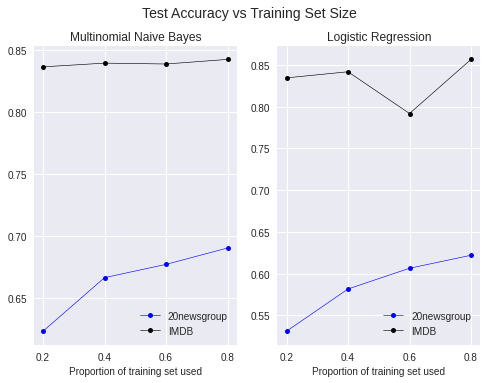

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

x = [0.2,0.4,0.6,0.8]
y1 = [0.6230, 0.6662, 0.6769, 0.6901 ]
y2 = [0.8362, 0.8392, 0.8385, 0.8422 ]
y3 =  [0.5311, 0.5817, 0.6065, 0.6221]
y4 = [0.8346, 0.8419, 0.7919, 0.8567 ]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Test Accuracy vs Training Set Size',  fontsize=14)
#plt.xlabel('Proportion of training used', fontsize=11) 
ax1.set_xlabel('Proportion of training set used', fontsize=10)
ax2.set_xlabel('Proportion of training set used', fontsize=10)
ax1.plot(x,y1,'bo-', label='20newsgroup', markersize=5, linewidth=0.6)
ax1.plot(x,y2,'ko-', label='IMDB', markersize=5, linewidth=0.6)
ax1.legend()
ax1.set_title('Multinomial Naive Bayes')
ax2.plot(x,y3,'bo-', label='20newsgroup', markersize=5, linewidth=0.6)
ax2.plot(x,y4,'ko-', label='IMDB', markersize=5, linewidth=0.6)
ax2.legend()
ax2.set_title('Logistic Regression')
plt.show()

### **Train on IMDb dataset with stopwords**

In [ ]:
# Use best hyperparameters for this experiment
hyperparameters_nb = {'max_df': (0.35,), 'min_df': (2,), 'use_idf': (False,), 'ngram_range': ((1, 1),), 'tf': (True,), 'alpha': (0.5,)}
hyperparameters_lr = {'max_df': (0.2,), 'min_df': (10,), 'use_idf': (False,), 'ngram_range': ((1, 1),), 'tf': (False,), 'max_iters': (100,), 'learning_rate': (0.1,), 'regularization': ('l2',), 'reg_constant': (0,)}

import tarfile
# Uncompress the tar.gz dataset
tar = tarfile.open('aclImdb_v1.tar.gz', "r:gz")
tar.extractall()
tar.close()

# Imdb sentiment dataset

# Load imdb dataset
train_imdb, test_imdb = load_imdb(data_path='', label_type='binary')

cp_imdb = CorpusPreproc(lemmatizer=True,
                        remove_stopwords=True,
                        remove_punc=True)

# Preprocess train set
X_imdb_train = cp_imdb.preproc(train_imdb['data'])
y_imdb_train = np.array(train_imdb['target'])
n_classes = np.unique(y_imdb_train).shape[0]

# Vectorize in url space so that you get counts for each url/movie rather than counts per review
url_train = review_to_url(X_imdb_train, data_path='')
# Identify the words that come up in only one url/movie
v = Vectorizer({'max_df': 1, # This is the max number of movies in which a word has to be found to be called a stop_word
                'min_df': 0.0,
                'use_idf': False,
                'ngram_range': (1, 1),
                'tf': False})
url_train = v.fit_transform(url_train)
stop_words = v.get_feature_names() # Remove these from future vectorization by calling them stop-words

# Load K-fold splits
imdb_splits = cross_validation_split(X_imdb_train, y_imdb_train, stratify=y_imdb_train, K=5)

# ---- Tune for hyperparameters NAIVE BAYES ----
print("Tuning NAIVE BAYES on IMDB:")
samples, keys = random_search(hyperparameters_nb, n_samples=1, RAND=RAND)
best_params, best_metric = tuning_loop(imdb_splits, samples, keys, model_type='NaiveBayes', n_classes=n_classes, stop_words=stop_words, verbose=True)

# Final test set using best hyperparameters

# Preprocess test set
X_imdb_test = cp_imdb.preproc(test_imdb['data'])
y_imdb_test = np.array(test_imdb['target'])

# Vectorize data
if best_params['use_idf']:
    # If use_idf is true tf needs to be true
    best_params['tf'] = True

v = Vectorizer(best_params, stop_words=stop_words)
X_imdb_train_tmp = pd.DataFrame.sparse.from_spmatrix(v.fit_transform(X_imdb_train))
X_imdb_test = pd.DataFrame.sparse.from_spmatrix(v.transform(X_imdb_test))

# initialize model
model = NaiveBayes(best_params, n_classes=n_classes)

# Train and test
model.fit(X_imdb_train_tmp, y_imdb_train)
y_pred = model.predict(X_imdb_test)
test_acc = model.evaluate_acc(y_imdb_test, y_pred)
print('Test accuracy using best hyperparameters NAIVE BAYES on IMDB: ' + str(test_acc))

Tuning NAIVE BAYES on IMDB:

Hyperparameters:
{'max_df': 0.35, 'min_df': 2, 'use_idf': False, 'ngram_range': (1, 1), 'tf': True, 'alpha': 0.5}
Accuracy: 0.867

Best hyperparameters NaiveBayes:
{'max_df': 0.35, 'min_df': 2, 'use_idf': False, 'ngram_range': (1, 1), 'tf': True, 'alpha': 0.5}
Best average validation metric NaiveBayes: 0.867
Test accuracy using best hyperparameters NAIVE BAYES on IMDB: 0.84328


In [ ]:
# ---- Tune for hyperparameters LOGISTIC REGRESSION ----
print("Tuning LOGISTIC REGRESSION:")
samples, keys = random_search(hyperparameters_lr, n_samples=1, RAND=RAND)
best_params, best_metric = tuning_loop(imdb_splits, samples, keys, model_type='LogisticRegression', n_classes=n_classes, verbose=True)

# Preprocess test set
X_imdb_test = cp_imdb.preproc(test_imdb['data'])
y_imdb_test = np.array(test_imdb['target'])

# Vectorize data
if best_params['use_idf']:
    # If use_idf is true tf needs to be true
    best_params['tf'] = True

v = Vectorizer(best_params, stop_words=stop_words)
X_imdb_train_tmp = pd.DataFrame.sparse.from_spmatrix(v.fit_transform(X_imdb_train))
X_imdb_test = pd.DataFrame.sparse.from_spmatrix(v.transform(X_imdb_test))

# initialize model
model = LogisticRegression(best_params, n_classes=n_classes)

# Train and test
model.fit(X_imdb_train_tmp, y_imdb_train)
y_pred = model.predict(X_imdb_test)
test_acc = model.evaluate_acc(y_imdb_test, y_pred)
print('Test accuracy using best hyperparameters LOGISTIC REGRESSION on IMDB: ' + str(test_acc))

Tuning LOGISTIC REGRESSION:

Hyperparameters:
{'max_df': 0.2, 'min_df': 10, 'use_idf': False, 'ngram_range': (1, 1), 'tf': False, 'max_iters': 100, 'learning_rate': 0.1, 'regularization': 'l2', 'reg_constant': 0}
Accuracy: 0.8703999999999998

Best hyperparameters LogisticRegression:
{'max_df': 0.2, 'min_df': 10, 'use_idf': False, 'ngram_range': (1, 1), 'tf': False, 'max_iters': 100, 'learning_rate': 0.1, 'regularization': 'l2', 'reg_constant': 0}
Best average validation metric LogisticRegression: 0.8703999999999998
Test accuracy using best hyperparameters LOGISTIC REGRESSION on IMDB: 0.86376


# Accuracy vs Epoch plot for Softmax Regression

Redefine the fit function of LogisticRegression to take in the validation set to calculate validation accuracy at each epoch. Modify the KFoldCV for same purpose.

In [ ]:
def fit(self, x, y, x_val, y_val):
    x = scipy.sparse.hstack((scipy.sparse.csr_matrix(np.ones((x.shape[0], 1))), x))
    x_val = scipy.sparse.hstack((scipy.sparse.csr_matrix(np.ones((x_val.shape[0], 1))), x_val))
    classes = np.unique(y)
    self.weights = np.zeros((x.shape[1], len(classes)))
    y_c = np.zeros((len(y), len(classes)))
    for i, val in enumerate(y):
        y_c[i, int(val)] = 1

    train_acc = []
    val_acc = []
    for epoch in range(self.max_iters):

        softm = softmax(x @ self.weights)
        softm_val = softmax(x_val @ self.weights)

        train_acc.append(self.evaluate_acc(y, np.argmax(softm, axis=1)))
        val_acc.append(self.evaluate_acc(y_val, np.argmax(softm_val, axis=1)))

        diff = softm - y_c
        grad = (x.T @ diff)
        if self.regul_type == "l2":
            self.weights -= (self.learning_rate * (grad + self.regul_const * self.weights))
        else:
            self.weights -= (self.learning_rate * (grad + self.regul_const * np.sign(self.weights)))

    self.weights = self.weights.T
    return classes, train_acc, val_acc

LogisticRegression.fit = fit


def plot_accuracy(split, model):
    _, train_acc, val_acc = model.fit(split['train']['X'], split['train']['y'], split['val']['X'], split['val']['y'])
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch #')
    plt.legend()
    plt.show()

Generate plot for IMDb

Plot Accuracy vs. Epoch for Logistic regression on IMDB using LR 0.1:


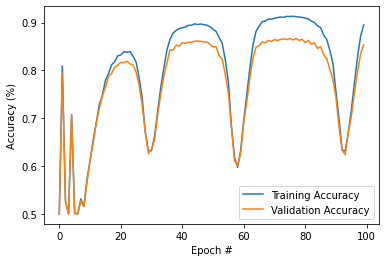

In [ ]:
# Use best hyperparameters for this experiment
hyperparameters_lr = {'max_df': 0.2, 'min_df': 10, 'use_idf': False, 'ngram_range': (1, 1), 'tf': False, 'max_iters': 100, 'learning_rate': 0.1, 'regularization': 'l2', 'reg_constant': 0}

import tarfile
# Uncompress the tar.gz dataset
tar = tarfile.open('aclImdb_v1.tar.gz', "r:gz")
tar.extractall()
tar.close()

# Imdb sentiment dataset

# Load imdb dataset
train_imdb, test_imdb = load_imdb(data_path='', label_type='binary')

cp_imdb = CorpusPreproc(lemmatizer=True,
                        remove_stopwords=True,
                        remove_punc=True)

# Preprocess train set
X_imdb_train = cp_imdb.preproc(train_imdb['data'])
y_imdb_train = np.array(train_imdb['target'])
n_classes = np.unique(y_imdb_train).shape[0]

# Load K-fold splits
imdb_splits = cross_validation_split(X_imdb_train, y_imdb_train, stratify=y_imdb_train, K=5)

# Vectorize the first split (only doing this analysis on the first)
v = Vectorizer(hyperparameters_lr)

split_tune = {'train': {'X': v.fit_transform(imdb_splits[0]['train']['X']).copy(),
                        'y': imdb_splits[0]['train']['y']},
              'val': {'X': v.transform(imdb_splits[0]['val']['X']).copy(),
                      'y': imdb_splits[0]['val']['y']}}
# initialize model
model = LogisticRegression(hyperparameters_lr, n_classes=n_classes)
# ---- Tune for hyperparameters NAIVE BAYES ----
print("Plot Accuracy vs. Epoch for Logistic regression on IMDB using LR 0.1:")
plot_accuracy(split_tune, model)


Generate plot for 20 newsgroups

Plot Accuracy vs. Epoch for Logistic regression on IMDB using LR 0.0001:


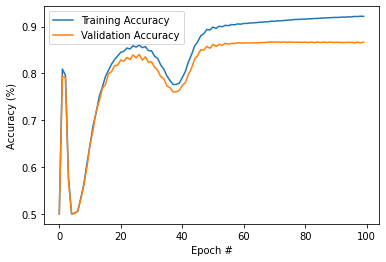

In [ ]:
# Recreate same plot with LR 0.0001
hyperparameters_lr['learning_rate'] = 0.0001

# Vectorize the first split (only doing this analysis on the first)
v = Vectorizer(hyperparameters_lr)

split_tune = {'train': {'X': v.fit_transform(imdb_splits[0]['train']['X']).copy(),
                        'y': imdb_splits[0]['train']['y']},
              'val': {'X': v.transform(imdb_splits[0]['val']['X']).copy(),
                      'y': imdb_splits[0]['val']['y']}}
# initialize model
model = LogisticRegression(hyperparameters_lr, n_classes=n_classes)
# ---- Tune for hyperparameters NAIVE BAYES ----
print("Plot Accuracy vs. Epoch for Logistic regression on IMDB using LR 0.0001:")
plot_accuracy(split_tune, model)